In [61]:
#import packages 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [168]:
#import train data
train = pd.read_csv("training_set.txt",sep=" .	",engine='python', names=["sentence","emotion"],skiprows=1 )

In [169]:
#preprocessing
train.dropna(inplace=True)
train.emotion=train.emotion-1
train.emotion=train.emotion.astype("int")
train= train.reset_index(drop=True)

In [170]:
train= train.reset_index(drop=True)
train

,sentence,emotion
0,I'm too old to be traded in,5
1,Mother said you could always tell a lady by he...,7
2,I always said I'd leave off when the time came,5
3,He'll be safe with me,1
4,Lay off,0
...,...,...
13528,"Yes , Commissioner",7
13529,The ring,6
13530,That is my greatest and most enduring love,4
13531,"When I came back from the war , I had a son",4


In [171]:
#feature extraction 
vectorizer = TfidfVectorizer(stop_words="english", max_df=.8)
X = vectorizer.fit_transform(train.sentence).toarray()
Y = train.emotion
X.shape, Y.shape

((13533, 7011), (13533,))

In [ ]:
#training 

In [172]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np

class Classifier(object):
    """ Multi-class Classifier base class """

    def __init__(self, input_size, n_classes):
        """
        Initializes a matrix in which each column will be the weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        self.parameters = np.zeros((input_size+1, n_classes)) # input_size +1 to include the Bias term

    def train(self, X, Y, devX, devY, epochs=20):
        """
        This trains the model over a certain number of epoch and records the
            accuracy in Training and Dev sets along each epoch.
        :param X: numpy array with size NxM where N is the number of training examples
                 and M is the number of features.
        :param Y: numpy array with size N containing the correct labels for the training set
        :param devX (optional): same as X but for the dev set.
        :param devY (optional): same as Y but for the dev set.
        :param epochs (optional): number of epochs to run.
        """
        train_accuracy = [self.evaluate(X, Y)]
        dev_accuracy = [self.evaluate(devX, devY)]
        
        for epoch in range(epochs):
            for i in tqdm(range(X.shape[0])):
                self.update_weights(X[i, :], Y[i])
                
            train_accuracy.append(self.evaluate(X, Y))
            dev_accuracy.append(self.evaluate(devX, devY))
            
        return train_accuracy, dev_accuracy
        

    def evaluate(self, X, Y):
        """
        Evaluates the model's predictions for a given set of examples.
        :param X: numpy array with size NxM where N is the number of examples to 
                    evaluate and M is the number of features.
        :param Y: numpy array with size N containing the correct labels for the training set
        """
        correct_predictions = 0
        for i in range(X.shape[0]):
            y_pred = self.predict(X[i, :])
            if Y[i] == y_pred:
                correct_predictions += 1
        return correct_predictions/X.shape[0]


    def plot_train(self, train_accuracy, dev_accuracy):
        """
        Function to plot the accuracy of the Training set and Dev set per epoch.
        :param train_accuracy: list containing the accuracies of the train set.
        :param dev_accuracy: list containing the accuracies of the dev set.
        """
        x_axis = [epoch+1 for epoch in range(len(train_accuracy))]
        plt.plot(x_axis, train_accuracy, '-g', linewidth=1, label='Train')
        plt.xlabel("epochs")
        plt.ylabel("Accuracy")
        plt.plot(x_axis, dev_accuracy, 'b-', linewidth=1, label='Dev')
        plt.legend()
        plt.show()


    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will 
            update the model parameters.
        
        :param x: Array of size M where M its the number of features that the model 
                  takes as input.
        :param y: The int corresponding to the correct label.
        
        Child classes must implement this function
        """
        pass

    def predict(self, x):
        """
        This function will add a Bias value to the received input, multiply the weights 
            corresponding to the different classeswith the input vector and choose the 
            class that maximizes that multiplication.
        
        :param x: numpy array with size 1xN where N = number of features.
        
        Child classes must implement this function
        """
        pass

In [173]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

class MultinomialLR(Classifier):
    """ Multinomial Logistic Regression """

    def __init__(self, input_size, n_classes, lr=0.001):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        :lr: learning rate (optional)
        """
        Classifier.__init__(self, input_size, n_classes)
        self.lr = lr

    def predict(self, input):
        """
        This function will add a Bias value to the received input, multiply the 
            Weights corresponding to the different classeswith the input vector, run 
            a softmax function and choose the class that achieves an higher probability.
        :param x: numpy array with size 1xN where N = number of features.
        """
        return np.argmax(self.softmax(np.dot(np.append(input, [1]), self.parameters)))

    def softmax(self, x):
        """ Computes softmax values for each sets of scores in x."""
        return np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)), axis=0)

    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will update
            the model parameters.
        :param x: Array of size M where M its the number of features that the model takes as input.
        :param y: The int corresponding to the correct label.
        """
        linear = np.dot(np.append(x, [1]), self.parameters)
        predictions = self.softmax(linear)
        
        self.parameters = self.parameters - self.lr*(np.outer(predictions, np.append(x, [1])).T)
        self.parameters[:, y] = self.parameters[:, y] + self.lr*np.append(x, [1])

In [1]:
lr  = MultinomialLR(X.shape[1], len(np.unique(Y)))
lr.parameters.shape

NameError: name 'MultinomialLR' is not defined

In [175]:
#validation data
val = pd.read_csv("dev_set.txt",sep=" .	",engine='python', names=["sentence","emotion"],skiprows=1 )
val.dropna(inplace=True)
val.emotion=val.emotion-1
val.emotion=val.emotion.astype("int")
val= val.reset_index(drop=True)

X_test = vectorizer.transform(val.sentence).toarray()
Y_test = val.emotion
X_test.shape, Y_test.shape

((968, 7011), (968,))

In [176]:
train_acc, dev_acc = lr.train(X, Y, devX=X_test, devY=Y_test, epochs=10)

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

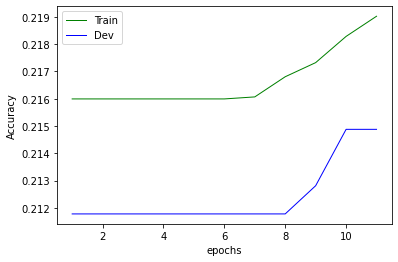

In [177]:
lr.plot_train(train_acc, dev_acc)

In [182]:
class MultiClassPerceptron(Classifier):
    """ Multi Class Perceptron """

    def __init__(self, input_size, n_classes):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        Classifier.__init__(self, input_size, n_classes)

    def predict(self, x):
        """
        This function will add a Bias value to the received input, multiply the Weights 
             corresponding to the different classes with the input vector and choose the class 
             that maximizes that multiplication.
        :param x: numpy array with size 1xM where M = number of features.
        """
        
        # your code here
        return np.argmax(np.dot(np.append(x, [1]), self.parameters))

    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will update the 
            model parameters.
        :param x: Array of size M where M its the number of features that the model takes as input.
        :param y: The int corresponding to the correct label.
        """
        
        # your code here-
        y_pred = self.predict(x)
        if y != y_pred:
            self.parameters[:, y] += np.append(x, [1])
            self.parameters[:, y_pred] -=  np.append(x, [1])
        

In [179]:
perceptron = MultiClassPerceptron(X.shape[1], len(np.unique(Y)))

In [180]:
train_acc, dev_acc = perceptron.train(X, Y, devX=X_test, devY=Y_test, epochs=5)

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

  0%|          | 0/13533 [00:00<?, ?it/s]

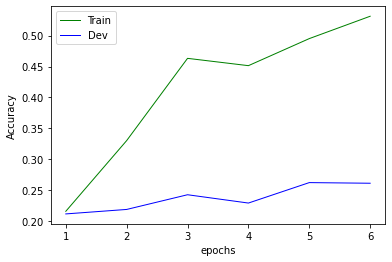

In [181]:
perceptron.plot_train(train_acc, dev_acc)